# Pattern matching


We will start in the same way as the last notebook started  - by downloading/importing the packages needed and importing the .csv file(s) needed. In this case, we only need the .csv file that has the matched abstracts as we are specifically looking at person-first and identity-first patterns that are "about" autism (or ASD, Asperger's syndrome, etc.). 

We could use the same basic approach to look at person-first and identity-first language for other conditions for which there are good noun and adjective forms of the words (diabetes? obesity? cancer? something else?). Doing that would mean using the .csv file with all of the abstracts or potentially creating and entirely new file of abstracts matched to another condition of interest. However, that lies outside the scope of this research, so I will not address it further here. 

## Get ready 

As always, we start with code that:
* loads up and nicknames some useful packages, 
* checks file locations,
* imports files, and 
* checks them. 


In [1]:
%%capture

# installing necessary pdf conversion packages via pip
# the '%%capture' at the top of this cell suppresses the output (which is normally quite long and annoying looking). 
# You can remove or comment it out if you prefer to see the output. 
!pip install nltk
!pip install spacy -q
!python -m spacy download en_core_web_lg -q

import os                         # os is a module for navigating your machine (e.g., file directories).
import nltk                       # nltk stands for natural language tool kit and is useful for text-mining. 
from nltk import word_tokenize    # and some of its key functions
from nltk import sent_tokenize  
tokenizer = nltk.tokenize.punkt.PunktSentenceTokenizer()
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
from nltk.corpus import wordnet                    # Finally, things we need for lemmatising!
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
nltk.download('averaged_perceptron_tagger')        # Like a POS-tagger...
nltk.download('wordnet')
nltk.download('webtext')
from nltk.corpus import webtext

import pandas as pd
pd.set_option('display.max_colwidth', 200)
import numpy as np
import statistics

import csv                        # csv is for importing and working with csv files

from collections import Counter

import statistics
import re                         # things we need for RegEx corrections
import string 
import spacy 
from spacy.matcher import Matcher 
from spacy.tokens import Span 
from spacy import displacy 
nlp = spacy.load('en_core_web_lg')
nlp.max_length = 1500000 #or any large value, as long as you don't run out of RAM

import math
import matplotlib.pyplot as plt
print(os.listdir("..\\output")  )      

## Import

Having checked the contents of the output folder and seen the files we expected to see, we can now import the specific file of interest for this step of the analysis.

In [2]:
matched_texts = pd.read_csv('..\\output\\matched_abstracts_no_null_texts.csv')    # one for just those that match the keyword
len(matched_texts)                                                                # check the length 

3794

## Cleaning phase

Cleaning begins by turning any instances of extra whitespaces (two or more in a row) into a single whitespace. Then, identifying any run-on sentences (where a lowercase letter, a full stop, and an uppercase letter are clustered without a whitespace) and inserting a whitespace between the full stop and the uppercase letter. Both of these steps will improve the sentence tokenisation that happens next. 

Then, we proceed to sentence tokenising the text. Like word tokens, sentence tokens become the unit for analysisis. As a trivial example, sentence tokenisation would turn a short text such as 


''' The cat named Cat is one of five cats. Honestly, I wonder why I have so many cats.
''' 

into a list of sentence tokens like

''' [[The cat named Cat is one of five cats.]

[Honestly, I wonder why I have so many cats.]]

''' 

An important difference is that the punctuation within the sentences that contributes to its structured and meaning (e.g. the comma and the full stops) are retained. This punctuation, like the capitalisation at the start of the sentences or for the poper nouns, is also retained as it helps the sentence-tokenisation process identify the words within the sentence correctly for their parts of speech (e.g. which of the words are nouns, verbs, etc. ). 



The sentence tokens are then put on individual rows, filtered to retain only those that contain one or more of the keywords of interest, and then filtered to ensure that there are no empty rows or duplicates. 

In [3]:
def remove_errors (input):
    no_extra_spaces = re.sub(r'(\s)(\s+)', r'\1', input)               # turn 2+ sequential whitespaces into 1
    no_run_ons1 = re.sub(r'([a-z].)([A-Z])', r'\1 \2', no_extra_spaces) # identifies run-ons (e.g. "word.New sentence ")
    no_run_ons2 = re.sub(r'([A-Z].)([A-Z])', r'\1. \2', no_run_ons1) # identifies run-ons (e.g. "word.New sentence ")

    return(no_run_ons2)

In [4]:
no_run_ons = [remove_errors(abstract) for abstract in matched_texts['Text'] ] 
                                             # create abstract list without extra spaces/run-ons 
                                             # this is to improve sentence tokenisation later 
matched_texts['Sentence'] = no_run_ons       # copy the no extra space/run-on abstract list back into df as a new column

In [5]:
sentences  = [sent_tokenize(abstract) for abstract in matched_texts['Sentence'] ] # create tokenised list of cleaner abstracts
matched_texts['Sentence'] = sentences                                   # copy that list back into df as a new column
sentence_per_row = matched_texts.explode('Sentence')                    # explode column in new df with 1 row/sentence token
print("How many sentences in total: " + str(len(sentence_per_row)))     # check the length of new df
print(sentence_per_row[:2])                                              # have a look. For the first two rows, 
                                                                        # 'Text' should be same, but 'Sentence' should not  

How many sentences in total: 122020
   Unnamed: 0                                                   Title  \
0           0  Progress in sequencing and annotating the human genome   
0           0  Progress in sequencing and annotating the human genome   

  Session_Code         Authors_and_Affiliations  \
0        PS01.   Weissenbach Genoscope  Evry  F   
0        PS01.   Weissenbach Genoscope  Evry  F   

                                                                                                                                                                                                      Text  \
0  Despite the availability of most of the human genome sequence  the accu rate identification of genes on the DNA sequence remains to be continu ously improved and updated. This procedure relies on ...   
0  Despite the availability of most of the human genome sequence  the accu rate identification of genes on the DNA sequence remains to be continu ously improved and updated. This

In [6]:
matched_sentences = sentence_per_row[sentence_per_row['Sentence'].str.contains('[Aa]utis|ASD|AS|[Aa]sperger')]
                                                     # create a new data frame with only the sentences that contain keywords
print("How many matching sentences: " + str(len(matched_sentences)))            # check the length

How many matching sentences: 7242


In [7]:
matched_sentences = matched_sentences[~matched_sentences['Sentence'].isnull()]  # remove any rows with empty 'Sentence' column
matched_sentences = matched_sentences.drop_duplicates()                         # drop any duplicates
print("Now how many matching sentences: " + str(len(matched_sentences)))        # check length of remaining data frame

Now how many matching sentences: 6941


In working with the matching sentences, it became clear there were several common errors, variations on how things were written and other annoying minor differences in the texts that made the manual checking more time-consuming than it needed to be.

Further, the minor differences meant that the counting steps later on were counting "child with ASD" separately from "child with autism" when perhaps the more interesting distinction there is whether "child with autism/ASD" is more or less common than "patient with autism/ASD" or "proband with autism/ASD" or any other common person-nouns. 

Thus, this tidy_up_terminology function corrects several importing errors, spelling and style differences, and consolidates on terminology. 

In [8]:
def tidy_up_terminology (input):
    space1 = re.sub(r'([A-Z]).(A-Z)', r'\1. \2', input)              # turn 2+ sequential whitespaces into 1
    space2 = re.sub(r'([a-z])(disorder|disability|spectrum)', r'\1 \2', space1)  # turn 2+ sequential whitespaces into 1
    space3 = re.sub(r'([a-z])(disorder|spectrum)', r'\1 \2', space2)        # turn 2+ sequential whitespaces into 1
    space4 = re.sub(r'(spec) (trum)', r'\1\2', space3)               # turn 2+ sequential whitespaces into 1
    no_apost = re.sub(r'([Aa]sperger[\S*?]s)', r'asperger', space4)  # Removes any apostrophe and non-whitespace in asperger's
    lower1 = re.sub(r'Autis', r'autis', no_apost)
    lower2 = re.sub(r'[Aa]spergers|[Aa]sperger', r'asperger', lower1)
    lower3 = re.sub(r'[Ss]pectrums|[Ss]pectra', r'spectrum', lower2)
    lower4 = re.sub(r'[Ss]yndromes|[Ss]yndrome', r'syndrome', lower3)
    lower5 = re.sub(r'[Dd]isorders|Disorder', r'disorder', lower4)
    lower6 = re.sub(r'[Dd]iseases|Disease', r'disease', lower5)
    plur1 = re.sub(r'ASDs', r'autism', lower6)    
    AS0 = re.sub(r'(autism|asperger) (syndrome|spectrum) \(AS\)', r'autism', plur1)
    AS1 = re.sub(r'(autism|asperger) (syndrome|spectrum)', r'autism', AS0)
    AS2 = re.sub(r'asperger autism', r'autism', AS1)
    AS3 = re.sub(r'AS ', r'autism ', AS2)
    ASD0 = re.sub(r'autism spectrum disorder \(ASD\)', r'autism', AS3)   # turn 2+ sequential whitespaces into 1
    ASD1 = re.sub(r'autism spectrum disorder', r'autism', ASD0)   # turn 2+ sequential whitespaces into 1
    ASD2 = re.sub(r'(autistic|autism|asperger) disorder', r'autism', ASD1)
    ASD3 = re.sub(r'(autistic|autism|asperger) spectrum disorder', r'autism', ASD2)
    ASD4 = re.sub(r'(autistic|autism|asperger) spectrum', r'autism', ASD3)
    ASD5 = re.sub(r'(autism|autistic) disease', r'autism', ASD4)
    ASD6 = re.sub(r'ASD', r'autism', ASD5)
    ID1 = re.sub(r'[Ii]ntellectual [Dd]isability \(ID\)', r'ID', ASD6)
    ID2 = re.sub(r'[Ii]ntellectual [Dd]isability', r'ID', ID1)
    ID3 = re.sub(r'(ID and )(autism|ASD)', r'autism', ID2)
    ID4 = re.sub(r'(ID, )(autism|ASD)', r'autism', ID3)

    return(ID4)

In [9]:
 # Optional cell code block to test or understand what the tidy_up_terminology function does
    
tidy_test = "Autism spectrum intellectual disability and autism ID, ASD \
            Autisticspectrum autisticspectrumdisorder ASD \
            Asperger's syndrome asperger's syndrome \
            intellectual disability Intellectual Disability (ID)\
            aspergers syndrome autism spectrum  ASDs ASD ID, and autism "

tidy_up_terminology(tidy_test)

'autism autism autism            autism autism autism            autism autism            ID ID           autism autism  autism autism ID, and autism '

In [10]:
tidy_text = [tidy_up_terminology(sentence) for sentence in matched_sentences['Sentence'] ] 
                                             # create abstract list without extra spaces/run-ons 
                                             # this is to improve sentence tokenisation later 
matched_sentences['Sentence'] = tidy_text    # copy the no extra space/run-on abstract list back into df as a new column

In [11]:
backup = matched_sentences                    # A backup is useful at this step because the next may not go the way you expect

In [12]:
matched_sentences = backup                    # If you need the backup, re-run this step. 

## Extraction

Following the cleaning phase, we move on to the extraction phase. This has two parts, first for the person-first extraction and then for the identity-first extraction. 

The results of both extractions are saved in their own column to make it easy to read and also to allow for a single sentence-token to contain both kinds of patterns. 

### Person-first pattern

In [13]:
pattern_1 = [{"POS": "NOUN"},                                        # define the person-first pattern - start with a noun
             {'DEP':'amod', 'OP':"?"},                               # followed by an optional modifier
             {"TEXT": {"REGEX": "(with|by|from)"}},                  # followed by some words that set up the p-f pattern
             {'DEP':'amod', 'OP':"?"},                               # then space for up to three optional modifiers
             {'DEP':'amod', 'OP':"?"},
             {'DEP':'amod', 'OP':"?"},
             {"TEXT": {"REGEX": "(^[Aa]utis|^[Aa]sperger|^ASD|^AS$)"}}] # finally, the keywords (original format, just in case)

# Matcher class object 
matcher = Matcher(nlp.vocab)                                         # define a matcher class object
matcher.add("matching_1", [pattern_1])                               # add my three person-first patterns to it


In [14]:
def find_pattern_match(input):                                               # define a function that applies the person-first
    thingy = nlp(input)                                                       # matcher class object to strings
    match = matcher(thingy)                                                   # and returns any matches to the pattern(s)
    if match == []:
        out_value = ''
    else:
        hold_multi_spans = []
        for match_id, start, end in match:
                string_id = nlp.vocab.strings[match_id]  # Get string representation
                span = thingy[start:end]  # The matched span
                hold_multi_spans.append(span)
        out_value = hold_multi_spans
    return out_value

In [15]:
matched_sentences['Person-first'] = matched_sentences.apply(lambda row: find_pattern_match(row.Sentence), axis = 1)
                                                                        # apply the newly defined person-first matcher function
                                                                        # and store the returned output in a new column
len(matched_sentences)                                                  # double check length remains same

6941

### Identity-first pattern

In [16]:
pattern_a = [{'DEP':'amod', 'OP':"?"},                                 # same for identity-first patterns,
             {'DEP':'amod', 'OP':"?"},                                 # starting with two optional modifiers
             {"TEXT": {"REGEX": "(^[Aa]utis|^[Aa]sperger|^ASD|^AS$)"}}, # the keywords (original format, just in case)
             {'DEP':'amod', 'OP':"?"},                                 # then upt to three more optional modifiers
             {'DEP':'amod', 'OP':"?"},
             {'DEP':'amod', 'OP':"?"},
             {"POS": "NOUN"}]                                          # and then a noun

# Matcher class object                                         
matcher = Matcher(nlp.vocab) 
matcher.add("matching_2", [pattern_a])            # this overwrites the matcher object to identity-first

In [17]:
matched_sentences['Identity-first'] = matched_sentences.apply(lambda row: find_pattern_match(row.Sentence), axis = 1)
                                                                        # apply the newly overwritten matcher function
                                                                        # and store the returned output in a new column
len(matched_sentences)                                                  # check the length - why not?

6941

### Consolidation

Following the cleaning and extraction phases, the last phase is consolidation. This phase further refines the data by removing all the rows that do not contain a match for one or both of the patterns. For example, there would be a row for "The child was tested for autism." because it contains a keyword of interest. However, this sentence would be eliminated in the consolidation phase as the keyword does not fit into either the person-first or identity-first patterns. 

Further, this phase goes on to lemmatise the extracted patterns so that they can be counted more easily. This phase also lowercases all occurrences of "Autistic", "Autism", and "Asperger's" as well as removing the apostrophe, the 's' and any non-white characters that might intrude between the 'r' and the 's' of "Asperger's". This phase also removes any square brackets, quotes and extra commas introduced by the lemmatisation process. 

This phase ends by writing out the consolidated data frame to a .csv for manual inspection. I could not find a feasible way of identifying whether or not the nouns matched in the extraction phase are person-nouns or not. As the list is not a totally unreasonable length (in the hundreds) I found it workable to 
* open in excel, 
* save the file under another name (e.g. pattern_matches_reviewed), 
* order the entire data set alphabetically by 'Person-first', 
* scan through the ordered results check whether each result in the 'Person-first' column is about a person, 
* removing entire rows if the 'Person-first' match is not about a person (checking the 'Sentence' or 'Text' column if needed)
* re-order the entire data set alphabetically by 'Identity-first', 
* scan through the ordered results check whether each result in the 'Identity-first' column is about a person, 
* removing entire rows if the 'Identity-first' match is not about a person, 
* save file again. 

For example, 'association with autism' matches the person-first pattern but is not about a person, so this row was removed. Many more rows were removed in the 'Identity-first' matches as things like 'autistic behaviours' and 'autism testing' were removed for not being about people. 

NOTE: There were several instances of "ASD dataset" which are not easy to determine if they are about people or not. Do they mean dataset composed from blood tests taken as part of ASD testing? If so, each row in the data set would be a blood test with the possibility that more than one test comes from the same person. Or do they mean a pool of case records, each of which represents a single person? The former would not be "about people" but the second would. I did not remove these rows as we cannot be certain. Leaving them out would also have been a valid option, as long as the choice was clear. 

Coincidentally, during this manual checking part of the consolidation phase I learned that, in the context of human genetics research "proband" is a person-noun. 

In [18]:
matched_patterns = matched_sentences[(matched_sentences['Person-first'] != '') | (matched_sentences['Identity-first'] != '')]
                                                     # keep only rows w/ non-null 'Person-first' and/or 'Identity-first' columns
len(matched_patterns)                                # check length

1304

In [19]:
matched_patterns = matched_patterns.explode('Person-first')    # explode 'Person-first' column to create 1 row per match
                                                               # if there were two matches within the same sentence
len(matched_patterns)                                          # check the length

1305

In [20]:
matched_patterns = matched_patterns.explode('Identity-first')  # Do the same for 'Identity-first' column
len(matched_patterns)                                          # check the length

1360

In [21]:
matched_patterns                                               # have a look at them

,Unnamed: 0,Title,Session_Code,Authors_and_Affiliations,Text,Year,Email,Author,Affiliations,Sentence,Person-first,Identity-first
8,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with som...,2001.0,irma.jarvela@hus.fi,NaN,NaN,autism was first described in 1944 by a Viennese physi cian Hans asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with some modifications.,"(boys, with, autistic)","(autistic, psychopa)"
8,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with som...,2001.0,irma.jarvela@hus.fi,NaN,NaN,We report the analysis of13 candidate gene loci associated with autism and schizophrenia in 17Finnish autism families with autosomal dominant mode of inheritance.,,"(autism, families)"
8,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with som...,2001.0,irma.jarvela@hus.fi,NaN,NaN,Linkageto the previously reported predisposing loci for autism could not be repli cated with Finnish autism families.,,"(autism, families)"
21,400,Prader Willi and Angelman Syndromes in Chilean Patients. Clinical and Molecular Diagnosis.,P0295.,Curotto L. Santa Mar a A. Alliende F. Cort s INTA University of Chile SANTIAGO C,Prader Willi (PWS) and Angelman AS) syndromes are multigenic disorderscharacterized by developmental and neurobehavioral abnormalities. Dif ferent underlying genetic defects cause loss of expressi...,2001.0,malliend@uec.inta.uchile.cl,NaN,NaN,Sand autism patients have a deletion in 15q11 q13 whereas uniparental disomy( UP.,,"(autism, patients)"
21,400,Prader Willi and Angelman Syndromes in Chilean Patients. Clinical and Molecular Diagnosis.,P0295.,Curotto L. Santa Mar a A. Alliende F. Cort s INTA University of Chile SANTIAGO C,Prader Willi (PWS) and Angelman AS) syndromes are multigenic disorderscharacterized by developmental and neurobehavioral abnormalities. Dif ferent underlying genetic defects cause loss of expressi...,2001.0,malliend@uec.inta.uchile.cl,NaN,NaN,autism patients were evaluated with the consensus cri teria.,,"(autism, patients)"
...,...,...,...,...,...,...,...,...,...,...,...,...
3748,675,NaN,NaN,NaN,P0280Two cases of Cri Du Chat syndrome in the same family Spatial association of oppositely imprinted regions in late S-phase without a familial translocation or inversion. but not at other stag...,2004.0,NaN,NaN,NaN,"S/autism locus but no ribosomal genes, the AR.",,"(autism, locus)"
3765,1100,NaN,NaN,NaN,"P0473DNA-polymorphisms of NAT2 and MnSOD and and carcinomas through a signiÜcant increase of somatic G > T predisposition to breast cancer. transversion in the APC and KRAS genes. In particular,...",2004.0,NaN,NaN,NaN,autism genes.,,"(autism, genes)"
3776,1710,NaN,NaN,NaN,P0697How to prepare stable refe

In [22]:
Lem = WordNetLemmatizer()                         # Define a short way to call the WordNetLemmatizer

def consolidate_matched_patterns (input):         # 
    final_lemma_list = []
    temp_lemma_list = []
    for phrase in input:                       # start for loop looking at each pattern in the person-first pattern column
        phrase_as_string = str(phrase)                               # hold the current pattern
        words_in_phrase = phrase_as_string.split() # split the current pattern into words
        for word in words_in_phrase :                            # for each word in the split up words
            lemma = Lem.lemmatize(word)             # turn that word into a lemma
            temp_lemma_list.append(lemma)                # append that lemma to a temporary list
        string_lem = str(temp_lemma_list)              # turn that temporary list into a string
        stripped_lem = re.sub(r"\[|\]|\'|\,",'', string_lem)  # remove  square brackets, commas and '' marks from the string
        final_lemma_list.append(stripped_lem)        # append the string version of the list to the output list
        temp_lemma_list = []                               # ensure the temp variable is empty

    return(final_lemma_list)


In [23]:
person_lemma_list = consolidate_matched_patterns(matched_patterns['Person-first'])
identity_lemma_list = consolidate_matched_patterns(matched_patterns['Identity-first'])

In [24]:
matched_patterns['Person-first'] = person_lemma_list    # copy the person-first output to new column in data frame 
matched_patterns['Identity-first'] = identity_lemma_list  # copy the identity-first output to new column in data frame 
matched_patterns = matched_patterns.drop_duplicates()                         # drop any duplicates
matched_patterns                                                   # have a look at the data frame with its new columns

,Unnamed: 0,Title,Session_Code,Authors_and_Affiliations,Text,Year,Email,Author,Affiliations,Sentence,Person-first,Identity-first
8,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with som...,2001.0,irma.jarvela@hus.fi,NaN,NaN,autism was first described in 1944 by a Viennese physi cian Hans asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with some modifications.,boy with autistic,autistic psychopa
8,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with som...,2001.0,irma.jarvela@hus.fi,NaN,NaN,We report the analysis of13 candidate gene loci associated with autism and schizophrenia in 17Finnish autism families with autosomal dominant mode of inheritance.,,autism family
8,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with som...,2001.0,irma.jarvela@hus.fi,NaN,NaN,Linkageto the previously reported predisposing loci for autism could not be repli cated with Finnish autism families.,,autism family
21,400,Prader Willi and Angelman Syndromes in Chilean Patients. Clinical and Molecular Diagnosis.,P0295.,Curotto L. Santa Mar a A. Alliende F. Cort s INTA University of Chile SANTIAGO C,Prader Willi (PWS) and Angelman AS) syndromes are multigenic disorderscharacterized by developmental and neurobehavioral abnormalities. Dif ferent underlying genetic defects cause loss of expressi...,2001.0,malliend@uec.inta.uchile.cl,NaN,NaN,Sand autism patients have a deletion in 15q11 q13 whereas uniparental disomy( UP.,,autism patient
21,400,Prader Willi and Angelman Syndromes in Chilean Patients. Clinical and Molecular Diagnosis.,P0295.,Curotto L. Santa Mar a A. Alliende F. Cort s INTA University of Chile SANTIAGO C,Prader Willi (PWS) and Angelman AS) syndromes are multigenic disorderscharacterized by developmental and neurobehavioral abnormalities. Dif ferent underlying genetic defects cause loss of expressi...,2001.0,malliend@uec.inta.uchile.cl,NaN,NaN,autism patients were evaluated with the consensus cri teria.,,autism patient
...,...,...,...,...,...,...,...,...,...,...,...,...
3748,675,NaN,NaN,NaN,P0280Two cases of Cri Du Chat syndrome in the same family Spatial association of oppositely imprinted regions in late S-phase without a familial translocation or inversion. but not at other stag...,2004.0,NaN,NaN,NaN,"S/autism locus but no ribosomal genes, the AR.",,autism locus
3765,1100,NaN,NaN,NaN,"P0473DNA-polymorphisms of NAT2 and MnSOD and and carcinomas through a signiÜcant increase of somatic G > T predisposition to breast cancer. transversion in the APC and KRAS genes. In particular,...",2004.0,NaN,NaN,NaN,autism genes.,,autism gene
3776,1710,NaN,NaN,NaN,P0697How to prepare stable reference materials for genetic establish that treatm

In [25]:
matched_patterns.to_csv('..\\output\\pattern_matches_to_review.csv')        
                                                            # Write the data frame to a .csv for manual processing in excel

At this point, I open the file in Excel (for example), removed the brackets, quotation marks and commas in the Person-first lemmatised and Identity-first lemmatised columns, then sort by each of one of these columns. I then scan through the results, removing any rows that are obviously not about people (e.g. "autistic testing") and checking the 'Text' column on any that are unclear 'autistic quartets'). I then sort by the other column and repeat the step of reviewing and deleting non-person rows. Save under "pattern_matches_reviewed.csv" for the next step. 

## Chart person-first or identity-first by year

In [119]:
reviewed_matches = pd.read_csv('..\\output\\pattern_matches_reviewed.csv')    # one for just those that match the keyword
reviewed_matches.head()

,Unnamed: 0.1,Unnamed: 0,Title,Session_Code,Authors_and_Affiliations,Text,Year,Email,Author,Affiliations,Sentence,Person-first,Identity-first
0,3161,456,C Genetic determinants for social skill training outcomesin autism spectrum disorder,P09.024,NaN,"M. Becker1,2, U. Jonsson1,2,4, N. Choque Olsson1,2,5, S. BÃ¶lte1,2, K. Tammimies1,2 1Center of Neurodevelopmental Disorders (KIND), Division of Neuropsychiatry, Department of Women and Children's ...",2019,NaN,D. Li,"1,2, I. Rabkina1,2, S. Stamouli1,2, H. Jiao3,",GT) is one of the most common interventions for children and adolescents with autism (AS.,adolescent with autism,NaN
1,957,296,c hildren autism and mitochondrial DNA mutations,P02.038,NaN,In the data of the WHO (World Health Organization) the prevalence of autism in childrenis reported as 1 6 per 1000. The number in Bulgaria is currently unknown. But the hospitalizationof patients...,2011,NaN,B. I. Radeva,"Medical Center Ã¢ÂÂChildenÃ¢ÂÂs HealthÃ¢ÂÂ, Sofia, Bulgaria",In the 3 boys with autism we found the polymorphism T4216C (connected with predisposition to LH.,boy with autism,NaN
2,1484,654,"Identification of a novel missense mutation in HUWE1 (Xp11.2) segregating with intellectual disability in a large family, by Targeted High Throughput Sequencing.",P05.073,NaN,Genetic diagnosis in Intellectual Disability (ID) remains difficult because of the extreme genetic heterogeneity of this frequent condition. We report the case of a large 4 generation family with ...,2013,NaN,"Y. Alembik1, J. Lauer Zillhardt2, B. Gerard2, C. Redin3,4, B. Van Loon5, L. Castelnau6, J. Chelly6,7, J. Mandel2,3,4, A. Piton3,4","1Service de gÃ©nÃ©tique mÃ©dicale des HÃ´pitaux Universitaires de Strasbourg, Strasbourg, France, 2Laboratoire de diagnostic gÃ©nÃ©tique des HÃ´pitaux Universitaires de Strasbourg, Strasbourg, F...","ID, while a de novo missense was recently observed in a boy with autism but not in his more mildly affected brother.",boy with autism,NaN
3,1512,736,A NCAM2 deletion in a patient with autism,P06.16,NaN,"An 8 year old boy with autism spectrum disorder, speech delay, behavioural problems, disturbed sleep and macrocephaly presented in our genetics cli nic. He is the first child of non consanguineous...",2013,NaN,"C. Scholz1, D. Steinemann2, M. Arslan Kirchner1, M. Stuhrmann1, M. Roy3, J. Schmidtke1","1Institute of Human Genetics, Hannover Medical School, Hannover, Germany, 2Institute for Cellular and Molecular Pathology, Hannover Medical School, Hannover, Germany, 3Psychiatric Clinic, Hannov...","An 8 year old boy with autism, speech delay, behavioural problems, disturbed sleep and macrocephaly presented in our genetics cli nic.",boy with autism,NaN
4,1763,695,"S Chromosomal microarray analysis of patients with intellectual disability, autism or multiple congenital anomalies presenting for genetic services",P08.19,NaN,"Copy number variations (CNVs) are the most common identifiable causes of intellectual disability/developmental delay (ID/DD), autism spectrum disorders (ASDs), or multiple congenital anomalies (...",2014,NaN,"O. Palumbo , P . Palumbo, R. Stallone, T . Palladino, L. Zelante, M. Carella","IRCCS Casa Sollievo della Sofferenza, San Giovanni Rotondo, Italy","XP1 gene microdeletion in a boy with autism and speech delay, and a de novo intersti tial deletion of 0.122 Mb at 2q24.2 region harboring only TB.",boy with autism,NaN


In [230]:
print("There are " + 
      str(len(reviewed_matches)) + " rows in the post-manual review data frame coming from " +
      str(reviewed_matches['Title'].nunique()) +
      " unique titles.")

There are 360 rows in the post-manual review data frame coming from 204 unique titles.


In [229]:
print("There are " + 
      str(len(reviewed_matches)) + " rows in the post-manual review data frame coming from " +
      str(len(reviewed_matches[reviewed_matches["Person-first"].notnull() == True].groupby(['Title']).nunique())) +
      " unique titles.")

There are 360 rows in the post-manual review data frame coming from 95 unique titles.


In [222]:
len(reviewed_matches[reviewed_matches["Person-first"].notnull() == True].groupby(['Title']).nunique())



95

In [236]:
print("In total, there are " + str(reviewed_matches['Identity-first'].count()) +
      " examples of PFL, coming from " +
      str(len(reviewed_matches[reviewed_matches["Person-first"].notnull() == True].groupby(['Title']).nunique())) +
      " unique titles and with " +
      str(reviewed_matches['Person-first'].nunique()) + " uinique patterns. They are distributed as follows: ")
reviewed_matches.groupby(['Person-first'])['Title'].nunique().sort_values(ascending=False)

In total, there are 233 examples of PFL, coming from 95 unique titles and with 33 uinique patterns. They are distributed as follows: 


Person-first
patient with autism                     35
child with autism                       17
individual with autism                  14
boy with autism                          5
girl with autism                         4
family with autism                       3
people with autism                       2
subject with autism                      2
child with autistic                      2
patient with autistic                    2
male with autism                         2
boy with autistic                        2
patient with idiopathic autism           2
patient with severe autistic             1
patient with severe autism               1
patient with mild autism                 1
patient with high functioning autism     1
uncle with autism                        1
individual with idiopathic autism        1
adolescent with autism                   1
girl with atypical autism                1
child with simplex autism                1
child with severe autistic               

In [217]:
print("In total, there are " + 
      str(reviewed_matches['Person-first'].count()) + " examples of PFL, with " +
      str(reviewed_matches['Person-first'].nunique()) + " uinique patterns. They are distributed as follows: " )
reviewed_matches.groupby(['Identity-first'])['Title'].nunique().sort_values(ascending=False)

In total, there are 128 examples of PFL, with 33 uinique patterns. They are distributed as follows: 


Identity-first
autism patient                    48
autistic patient                  19
autism case                       13
autistic child                    13
autism dataset                    11
autistic individual                8
autism family                      7
autistic group                     6
autism cohort                      5
autistic population                5
autism group                       3
autism proband                     3
autistic proband                   3
autism trio                        3
African autistic population        2
autism child                       2
autism individual                  2
autism brother                     2
autistic case                      2
autistic subject                   1
unrelated autistic child           1
typical autism case                1
old autistic girl                  1
definite autistic case             1
homogeneous autism subgroup        1
large autism dataset               1
old autistic female    

In [181]:
reviewed_matches.groupby(['Identity-first'])['Title'].nunique()

Title
 20 ans aprÃ¨s: a second family with mutation in X linked monoamine oxidase A gene affecting cognition and behavior                               0
 2p25 deletion: involvement of SNTG2 in autism or behavioral troubles, and parental imprinting.                                                   1
 8p rearrangements detected by array CGH in a 1500 cohort of patients with intellectual disability                                                0
 A c GH Array study in non syndromic (primary) autism disorder                                                                                    3
 A clinical study of patients with pericentromeric deletion and duplication within 16p11.2 p12.2                                                  0
                                                                                                                                                 ..
scanning copy number variations (cNV) in Angelman syndrome,  mental retardation and autism                

In [175]:
test = reviewed_matches.groupby(['Title']).nunique()
print(test['Person-first'][1])


0


In [176]:
reviewed_matches.groupby(['Title','Person-first']).nunique().count()

Unnamed: 0.1                112
Unnamed: 0                  112
Session_Code                112
Authors_and_Affiliations    112
Text                        112
Year                        112
Email                       112
Author                      112
Affiliations                112
Sentence                    112
Identity-first              112
dtype: int64

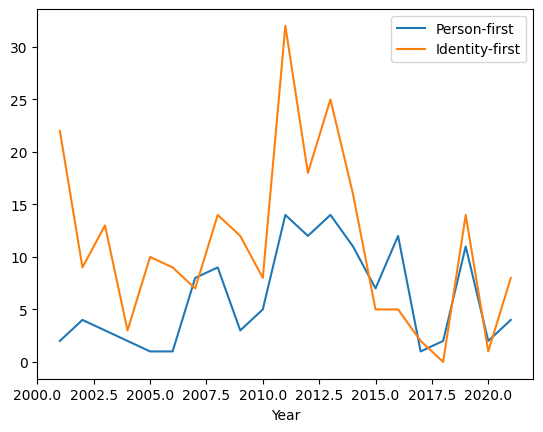

<Figure size 640x480 with 0 Axes>

In [35]:
person_identity_count.plot()
plt.show()
plt.savefig('..\\output\\matches_count.jpg')    # we can right click on the plot above to save it, or save it via command

In [36]:
person_examples = reviewed_matches.groupby(['Person-first'])['Person-first'].count()
identity_examples = reviewed_matches.groupby(['Identity-first'])['Identity-first'].count()
print(len(person_examples))
print(len(identity_examples))

33
48


In [37]:
person_identity_examples=pd.concat([person_examples,identity_examples],axis=1)


In [38]:
person_identity_examples.sort_values(by=['Person-first'], ascending=False).head(10)

,Person-first,Identity-first
patient with autism,46.0,NaN
child with autism,19.0,NaN
individual with autism,15.0,NaN
boy with autism,5.0,NaN
girl with autism,4.0,NaN
family with autism,3.0,NaN
patient with autistic,2.0,NaN
people with autism,2.0,NaN
boy with autistic,2.0,NaN
patient with idiopathic autism,2.0,NaN


In [39]:
person_identity_examples.sort_values(by=['Identity-first'], ascending=False).head(10)

,Person-first,Identity-first
autism patient,NaN,67.0
autistic patient,NaN,22.0
autism family,NaN,17.0
autism case,NaN,15.0
autistic child,NaN,14.0
autistic individual,NaN,12.0
autism dataset,NaN,11.0
autism cohort,NaN,7.0
autism child,NaN,6.0
autistic population,NaN,6.0


In [40]:
person_identity_examples.notnull().sum()

Person-first      33
Identity-first    48
dtype: int64

## Count abstracts by the structures they use

In [72]:
test = pd.merge(person_by_title,identity_by_title,on='Title',how='outer')
print(test)
print(type(test))

                                                                                                                                                Person-first  \
Title                                                                                                                                                          
 20 ans aprÃ¨s: a second family with mutation in X linked monoamine oxidase A gene affecting cognition and behavior                                        1   
 2p25 deletion: involvement of SNTG2 in autism or behavioral troubles, and parental imprinting.                                                            0   
 8p rearrangements detected by array CGH in a 1500 cohort of patients with intellectual disability                                                         1   
 A c GH Array study in non syndromic (primary) autism disorder                                                                                             1   
 A clinical study of patients with peric

In [68]:
person_by_title = reviewed_matches.groupby(['Title'])['Person-first'].count()
identity_by_title = reviewed_matches.groupby(['Title'])['Identity-first'].count()
title = pd.concat([person_by_title,identity_by_title],axis=1)
print(title)

                                                                                                                                                Person-first  \
Title                                                                                                                                                          
 20 ans aprÃ¨s: a second family with mutation in X linked monoamine oxidase A gene affecting cognition and behavior                                        1   
 2p25 deletion: involvement of SNTG2 in autism or behavioral troubles, and parental imprinting.                                                            0   
 8p rearrangements detected by array CGH in a 1500 cohort of patients with intellectual disability                                                         1   
 A c GH Array study in non syndromic (primary) autism disorder                                                                                             1   
 A clinical study of patients with peric

In [42]:
title.sort_values(by=['Identity-first'], ascending=False)

,Person-first,Identity-first
Title,,
Role of serotonin transporter promoter length polymorphism in autism: A south African population based study,0,9
Alport syndrome epidemiology in Greek Cypriots,0,7
Unexpectedly low prevalence of HLA B27 in Romanian ankylosing spondylitis patients,0,5
Thin basement membrane nephropathy due to heterozygous COL4A3/ COL4A4 mutations is a more frequent cause of end stage kidney disease compared to Alport syndrome,0,5
Polymorphism in Serotonin Transporter Gene in Autism,1,5
...,...,...
"C A new case of Bainbridge Ropers syndrome Ilona Jaszczuk1, Izabela Winkler2, Agnieszka Sobczy Åska Tomas zewska3, Aleksandra Pietrzyk3, Monika Lejman4, Wiktor Wojcza kowski5, Dorota Koczkodaj1 1Department of Cancer Genetics with Cytogenetic Laboratory, Medical University, Lublin, Poland,2StâJohns Center Oncology, Lublin, Poland,3MedGen Medical Centre, Warsaw, Poland,4Genetic Diagnostics, Department of Pediatric Hemathology, Oncology andTransplantology, Medical University, Lublin, Poland,5Department of Pediatric Hematology, Oncology and Transplantology, Lublin, Poland",1,0
"C A ZFHX4 mutation associated with a recognizable neuropsychological and facial phenotype Paolo Fontana 1, Monia Ginevrino2,3, Kristel Bejo2, Giuseppina Cantalupo1, Maria Ciavarella1, Cinzia Lombardi1, Marianna Maioli1, Francesca Scarano1, Antonio Novelli2,Fortunato Lonardo1 1AORN San Pio, Benevento, Italy,2Bambino GesÃ¹ Children âs Hospital, Roma, Italy,3UniversitÃ Cattolica del Sacro Cuore, Roma, Italy",1,0
Different phenotype with 22q13.3 deletion syndrome in two patients,1,0


In [43]:
title.sort_values(by=['Person-first'], ascending=False)

,Person-first,Identity-first
Title,,
c hildren autism and mitochondrial DNA mutations,4,0
Autism s pectrum Disorders and s eizure s yndrome,4,1
Clinical report: a new case of macrocephaly/autism syndrome ( MIM00 ) with a germline PTEN tumor suppressor gene mutation,3,0
"A A case of dihydropyrimidine dehydrogenase de ï¬ciency and homozygous mutation DPYD:c.1905 +1G>A in Bulgarian patient with severe autistic disorderAbstracts from the 52ndEuropean Society of Human Genetics (ESHG). . . 1335M. B. Ivanova1,2, V. Jordanova1, T. Todorov3,",3,0
A 2.2mb microduplication in 1q42.2 including DISC in 2 brothers with autism and mild mental retardation,3,0
...,...,...
t hree novel mutations in t urkish patients with Alstrom s yndrome,0,1
t NFalpha gene polymorphisms in Romanian HLA B27 positive patients with ankylosing spondylitis,0,2
molecular analysis of Prader Willi and Angelman syndromes: A study of twenty t unisian patients,0,3


In [44]:
columns = ['Person-first','Identity-first']
filter_ = (title[columns] > 0).all(axis=1)
title[filter_]
len(title[filter_])


20

In [45]:
title[filter_].sort_values(by=['Person-first'], ascending=False)

,Person-first,Identity-first
Title,,
Autism s pectrum Disorders and s eizure s yndrome,4,1
B MLPA analysis as a diagnostic test in patients withautism spectrum disorders,3,2
multiple minor congenital defects associated with autism spectrum disorders,2,2
Frequency of mosaic aneuploidy in children with idiopathic autism,2,1
Cytogenetic analysis in autistic disorder,2,2
M Array Comparative Genome Hybridization (aCGH) in children with autistic spectrum phenotype,2,1
Two cases with different microaberrations of the long arm of chromosome 15 and autism,2,1
cADHERiN 11 as a possible candidate gene for autism,1,2
Polymorphism in Serotonin Transporter Gene in Autism,1,5


In [46]:
title[filter_].sort_values(by=['Identity-first'], ascending=False)

,Person-first,Identity-first
Title,,
Polymorphism in Serotonin Transporter Gene in Autism,1,5
Abnormal growth and dysmorphic features in children with autism spectrum disorders,1,4
Microrrearrangements of human chromosome 15q11 q13 in families with autistic disorder,1,4
No evidence for an association with the serotonin transporter gene polymorphisms (5 HTTVNTR and 5 HTTLPR) and autism,1,3
A c GH Array study in non syndromic (primary) autism disorder,1,3
B MLPA analysis as a diagnostic test in patients withautism spectrum disorders,3,2
C Genetic determinants for social skill training outcomesin autism spectrum disorder,1,2
Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,1,2
Cytogenetic analysis in autistic disorder,2,2


In [47]:
has_pf = title[title['Person-first'] > 0]
has_both = has_pf[has_pf['Identity-first'] > 0]
print(len(has_both))
has_both

20


,Person-first,Identity-first
Title,,
A c GH Array study in non syndromic (primary) autism disorder,1,3
Autism s pectrum Disorders and s eizure s yndrome,4,1
Contribution of rare and common variants of the PTCHD1 gene to Autism Spectrum Disorder and Intellectual Disability,1,2
Cytogenetic analysis in autistic disorder,2,2
Genetic causes of pervasive developmental disorders,1,1
Identifying phenotypes and exploring genetic aetiology of autism spectrum disorders : a 87 patient study.,1,1
M Array Comparative Genome Hybridization (aCGH) in children with autistic spectrum phenotype,2,1
Two cases with different microaberrations of the long arm of chromosome 15 and autism,2,1
a c GH analysis of two families showing both autism and epilepsy,1,1


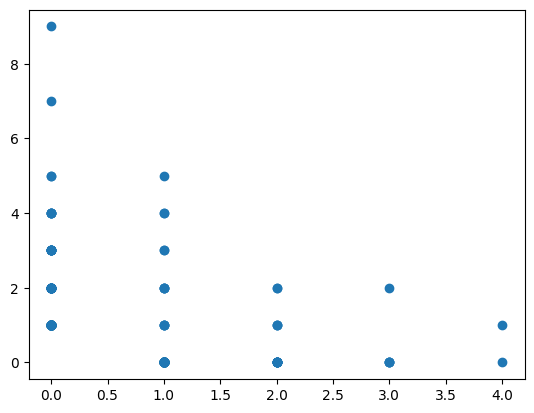

In [56]:
plt.scatter(title['Person-first'], title['Identity-first'])
plt.show()

#plt.savefig('..\\output\title_count.jpg')    # we can right click on the plot above to save it, or save it via command

In [66]:
title['Person-first']


Title
 20 ans aprÃ¨s: a second family with mutation in X linked monoamine oxidase A gene affecting cognition and behavior                               1
 2p25 deletion: involvement of SNTG2 in autism or behavioral troubles, and parental imprinting.                                                   0
 8p rearrangements detected by array CGH in a 1500 cohort of patients with intellectual disability                                                1
 A c GH Array study in non syndromic (primary) autism disorder                                                                                    1
 A clinical study of patients with pericentromeric deletion and duplication within 16p11.2 p12.2                                                  2
                                                                                                                                                 ..
scanning copy number variations (cNV) in Angelman syndrome,  mental retardation and autism                

In [ ]:
ax = plt.axes()
ax.scatter(x, y, c='g', marker='x')
ax.set_title("Anscombe's First Data Set")
ax.set_ylabel('Y-Values')
ax.set_ylim(4, 11)
ax.set_xlabel('X-Values')
ax.set_xlim(3, 15)

plt.show()